In [1]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd
from pandas_datareader import data # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import datetime as dt # For defining dates
# import mplfinance as mpf # Matplotlib finance

import time

# Used to get data from a directory
import os
from os import listdir
from os.path import isfile, join

#Statsmodels is a great library we can use to run regressions.
import statsmodels.api as sm
# Seaborn extends the capabilities of Matplotlib
import seaborn as sns
# Used for calculating regressions
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [2]:
#change the tickers here according to what's in the portfolio
tickers = ['LHX','ODFL','SAIA','AXP','TROW','CG','CSWC','CBRE','SBAC','EPAM','QCOM','ASML','DSGX',
          'MGIC','RDWR','CTLT','BRKR','ICLR','MODV','^FVX']

start_date = '2017-01-01'
end_date = '2021-12-31'

panel_data = data.DataReader(tickers,'yahoo', start_date, end_date)

In [3]:
#check that all stocks have the same amount of data otherwise change the date range

adj_close = panel_data['Adj Close']
adj_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2017-01-03 to 2021-12-31
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   LHX     1259 non-null   float64
 1   ODFL    1259 non-null   float64
 2   SAIA    1259 non-null   float64
 3   AXP     1259 non-null   float64
 4   TROW    1259 non-null   float64
 5   CG      1259 non-null   float64
 6   CSWC    1259 non-null   float64
 7   CBRE    1259 non-null   float64
 8   SBAC    1259 non-null   float64
 9   EPAM    1259 non-null   float64
 10  QCOM    1259 non-null   float64
 11  ASML    1259 non-null   float64
 12  DSGX    1259 non-null   float64
 13  MGIC    1259 non-null   float64
 14  RDWR    1259 non-null   float64
 15  CTLT    1259 non-null   float64
 16  BRKR    1259 non-null   float64
 17  ICLR    1259 non-null   float64
 18  MODV    1259 non-null   float64
 19  ^FVX    1259 non-null   float64
dtypes: float64(20)
memory usage: 206.6 KB


## Function that saves dataframe to CSV

In [9]:
def save_dataframe_to_csv(kind, df, ticker):
    df.to_csv(kind + ticker + '.csv')

In [10]:
# for ticker in tickers:
#     panel_data = data.DataReader(ticker,'yahoo', start_date, end_date)
# #     close = panel_data['Close']
#     adj_close = panel_data['Adj Close']
#     save_dataframe_to_csv('adj_close', adj_close, ticker)

## Function that returns dataframe from a CSV

In [11]:
def get_df_from_csv(kind, ticker):
    try:
        df = pd.read_csv(kind + ticker + '.csv', index_col='Date', 
                         parse_dates=True)
    except FileNotFoundError:
        pass
        # print("File Doesn't Exist")
    else:
        return df

## Add Daily Return to dataframe

In [12]:
def add_daily_return_to_df(kind, df, ticker):
    df['daily_return'] = (df['Adj Close'] / df['Adj Close'].shift(1)) - 1
    # Save data to a CSV file
    save_dataframe_to_csv(kind, df, ticker)
    return df

In [13]:
for ticker in tickers:
    df = get_df_from_csv('adj_close', ticker)
    add_daily_return_to_df('adj_close', df, ticker)

## Merge multiple stocks in one dataframe by col name

In [14]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
    # Will hold data for all dataframes with the same column name
    mult_df = pd.DataFrame()
    
    for x in tickers:
        df = get_df_from_csv('adj_close', x)
        
        # NEW Check if your dataframe has duplicate indexes
        if not df.index.is_unique:
            # Delete duplicates 
            df = df.loc[~df.index.duplicated(), :]
        
        mask = (df.index >= sdate) & (df.index <= edate)
        mult_df[x] = df.loc[mask][col_name]
        
    return mult_df

## Get stock prices on date

In [15]:
def get_prices_on_date(stocks_df, date):
    return stocks_df.loc[pd.DatetimeIndex([date])]['Adj Close'].item()

## Returns the value of portfolio by date

In [16]:
def get_port_val_by_date(date, shares, tickers):
    port_prices = merge_df_by_column_name('Adj Close',  date, date, *port_list)
    # Convert from dataframe to Python list
    port_prices = port_prices.values.tolist()
    # Trick that converts a list of lists into a single list
    port_prices = sum(port_prices, [])
    
    # Create a list of values by multiplying shares by price
    value_list = []
    for price, share in zip(port_prices, shares):
        value_list.append(price * share)
    
    return sum(value_list)

## Find Daily Return for Whole Portfolio

In [17]:
def get_port_daily_return(sdate, edate, shares, tickers):
    # Merge all daily prices for all stocks into 1 dataframe
    mult_df = merge_df_by_column_name('Adj Close',  sdate, 
                                  edate, *port_list)
    
    # Get the number of stocks in portfolio
    num_cols = len(mult_df.columns)
    
    # Multiply each stock column by the number of shares
    i = 0
    while i < num_cols:
        mult_df[tickers[i]] = mult_df[tickers[i]].apply(lambda x: x * shares[i])
        i += 1
        
    # Create a new column with the sums of all stocks named Total
    mult_df['Total'] = mult_df.iloc[:, 0:num_cols].sum(axis=1)
    
    # Add column for portfolio daily return
    mult_df['daily_return'] = (mult_df['Total'] / mult_df['Total'].shift(1)) - 1
    
    return mult_df

In [18]:
#change to the list of stocks we using
port_list = ['LHX','ODFL','SAIA','AXP','TROW','CG','CSWC','CBRE','SBAC','EPAM','QCOM','ASML','DSGX',
          'MGIC','RDWR','CTLT','BRKR','ICLR','MODV','^FVX']

#add in the weightage of stocks
port_shares = [0.0145161,0.068463,0.0070209,0.00164655,0.01234755,0.0179883,0.0130176,0.033096,
               0.071904,0.0091785,2.43E-05,0.0103785,0.0060897,0.0027567,0.0015723,0.0087756,
               0.0066555,0.0100752,0.0044937,0.7]

# tot_port_df = get_port_daily_return('2020-01-02', '2020-12-31', 
#                                     port_shares, port_list)

#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2021-01-01', port_shares, port_list)
tot_port_df

,LHX,ODFL,SAIA,AXP,TROW,CG,CSWC,CBRE,SBAC,EPAM,...,DSGX,MGIC,RDWR,CTLT,BRKR,ICLR,MODV,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,1.361084,3.881016,0.315238,0.114898,0.799618,0.219965,0.166078,1.044841,7.444281,0.584303,...,0.129406,0.016184,0.023081,0.236941,0.140677,0.752718,0.172423,1.3608,19.856813,NaN
2017-01-04,1.368504,3.897116,0.316292,0.116782,0.811533,0.226310,0.170144,1.061720,7.454863,0.590728,...,0.130624,0.016302,0.023207,0.239662,0.142111,0.773977,0.176962,1.3629,19.967756,0.005587
2017-01-05,1.370226,3.851052,0.308569,0.115342,0.805207,0.229835,0.169941,1.052784,7.356104,0.594308,...,0.128797,0.016419,0.023097,0.236064,0.142437,0.767831,0.176153,1.3041,19.749337,-0.010939
2017-01-06,1.385332,3.850606,0.315098,0.115572,0.797299,0.234770,0.167705,1.032595,7.302493,0.613766,...,0.129406,0.016302,0.023034,0.235888,0.143676,0.792414,0.177276,1.3454,19.778517,0.001478
2017-01-09,1.353398,3.829586,0.309622,0.116169,0.767882,0.235475,0.169941,1.030278,7.265105,0.613491,...,0.129102,0.016302,0.022798,0.236151,0.145240,0.809744,0.175973,1.3167,19.656389,-0.006175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,2.625550,13.520541,1.302166,0.190518,1.747290,0.549053,0.204911,2.082731,19.580446,3.270667,...,0.363555,0.040638,0.042704,0.924158,0.360562,1.939577,0.617749,0.2548,54.607474,0.006635
2020-12-28,2.656179,13.292755,1.283631,0.192158,1.744698,0.550454,0.210971,2.084055,19.668017,3.245793,...,0.356369,0.040319,0.043474,0.902834,0.357177,1.928192,0.627231,0.2548,54.399523,-0.003808
2020-12-29,2.641574,13.239560,1.280121,0.191800,1.748469,0.547303,0.212702,2.055593,19.650217,3.228537,...,0.361667,0.041436,0.043427,0.901342,0.354656,1.949551,0.604268,0.2646,54.316168,-0.001532


## Get old data for portfolio

In [19]:
#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2021-01-01', 
                                    port_shares, port_list)
tot_port_df

,LHX,ODFL,SAIA,AXP,TROW,CG,CSWC,CBRE,SBAC,EPAM,...,DSGX,MGIC,RDWR,CTLT,BRKR,ICLR,MODV,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,1.361084,3.881016,0.315238,0.114898,0.799618,0.219965,0.166078,1.044841,7.444281,0.584303,...,0.129406,0.016184,0.023081,0.236941,0.140677,0.752718,0.172423,1.3608,19.856813,NaN
2017-01-04,1.368504,3.897116,0.316292,0.116782,0.811533,0.226310,0.170144,1.061720,7.454863,0.590728,...,0.130624,0.016302,0.023207,0.239662,0.142111,0.773977,0.176962,1.3629,19.967756,0.005587
2017-01-05,1.370226,3.851052,0.308569,0.115342,0.805207,0.229835,0.169941,1.052784,7.356104,0.594308,...,0.128797,0.016419,0.023097,0.236064,0.142437,0.767831,0.176153,1.3041,19.749337,-0.010939
2017-01-06,1.385332,3.850606,0.315098,0.115572,0.797299,0.234770,0.167705,1.032595,7.302493,0.613766,...,0.129406,0.016302,0.023034,0.235888,0.143676,0.792414,0.177276,1.3454,19.778517,0.001478
2017-01-09,1.353398,3.829586,0.309622,0.116169,0.767882,0.235475,0.169941,1.030278,7.265105,0.613491,...,0.129102,0.016302,0.022798,0.236151,0.145240,0.809744,0.175973,1.3167,19.656389,-0.006175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,2.625550,13.520541,1.302166,0.190518,1.747290,0.549053,0.204911,2.082731,19.580446,3.270667,...,0.363555,0.040638,0.042704,0.924158,0.360562,1.939577,0.617749,0.2548,54.607474,0.006635
2020-12-28,2.656179,13.292755,1.283631,0.192158,1.744698,0.550454,0.210971,2.084055,19.668017,3.245793,...,0.356369,0.040319,0.043474,0.902834,0.357177,1.928192,0.627231,0.2548,54.399523,-0.003808
2020-12-29,2.641574,13.239560,1.280121,0.191800,1.748469,0.547303,0.212702,2.055593,19.650217,3.228537,...,0.361667,0.041436,0.043427,0.901342,0.354656,1.949551,0.604268,0.2646,54.316168,-0.001532


## Forecasting

In [20]:
tot_port_df = tot_port_df.asfreq('d')
tot_port_df.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
               '2017-01-11', '2017-01-12',
               ...
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='Date', length=1459, freq='D')

In [21]:
# Delete NaNs for nontrading days
tot_port_df = tot_port_df.fillna(method='ffill')

In [22]:
tot_port_df

,LHX,ODFL,SAIA,AXP,TROW,CG,CSWC,CBRE,SBAC,EPAM,...,DSGX,MGIC,RDWR,CTLT,BRKR,ICLR,MODV,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,1.361084,3.881016,0.315238,0.114898,0.799618,0.219965,0.166078,1.044841,7.444281,0.584303,...,0.129406,0.016184,0.023081,0.236941,0.140677,0.752718,0.172423,1.3608,19.856813,NaN
2017-01-04,1.368504,3.897116,0.316292,0.116782,0.811533,0.226310,0.170144,1.061720,7.454863,0.590728,...,0.130624,0.016302,0.023207,0.239662,0.142111,0.773977,0.176962,1.3629,19.967756,0.005587
2017-01-05,1.370226,3.851052,0.308569,0.115342,0.805207,0.229835,0.169941,1.052784,7.356104,0.594308,...,0.128797,0.016419,0.023097,0.236064,0.142437,0.767831,0.176153,1.3041,19.749337,-0.010939
2017-01-06,1.385332,3.850606,0.315098,0.115572,0.797299,0.234770,0.167705,1.032595,7.302493,0.613766,...,0.129406,0.016302,0.023034,0.235888,0.143676,0.792414,0.177276,1.3454,19.778517,0.001478
2017-01-07,1.385332,3.850606,0.315098,0.115572,0.797299,0.234770,0.167705,1.032595,7.302493,0.613766,...,0.129406,0.016302,0.023034,0.235888,0.143676,0.792414,0.177276,1.3454,19.778517,0.001478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,2.625550,13.520541,1.302166,0.190518,1.747290,0.549053,0.204911,2.082731,19.580446,3.270667,...,0.363555,0.040638,0.042704,0.924158,0.360562,1.939577,0.617749,0.2548,54.607474,0.006635
2020-12-28,2.656179,13.292755,1.283631,0.192158,1.744698,0.550454,0.210971,2.084055,19.668017,3.245793,...,0.356369,0.040319,0.043474,0.902834,0.357177,1.928192,0.627231,0.2548,54.399523,-0.003808
2020-12-29,2.641574,13.239560,1.280121,0.191800,1.748469,0.547303,0.212702,2.055593,19.650217,3.228537,...,0.361667,0.041436,0.043427,0.901342,0.354656,1.949551,0.604268,0.2646,54.316168,-0.001532


In [23]:
# Delete all unneeded columns - basically delete all except Total
del_col = ['LHX','ODFL','SAIA','AXP','TROW','CG','CSWC','CBRE','SBAC','EPAM','QCOM','ASML','DSGX',
          'MGIC','RDWR','CTLT','BRKR','ICLR','MODV','^FVX', "daily_return"]

for x in del_col:
    tot_port_df = tot_port_df.drop([x], axis=1)

In [24]:
tot_port_df

,Total
Date,
2017-01-03,19.856813
2017-01-04,19.967756
2017-01-05,19.749337
2017-01-06,19.778517
2017-01-07,19.778517
...,...
2020-12-27,54.607474
2020-12-28,54.399523
2020-12-29,54.316168


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use t

Lags : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Observations : 1459


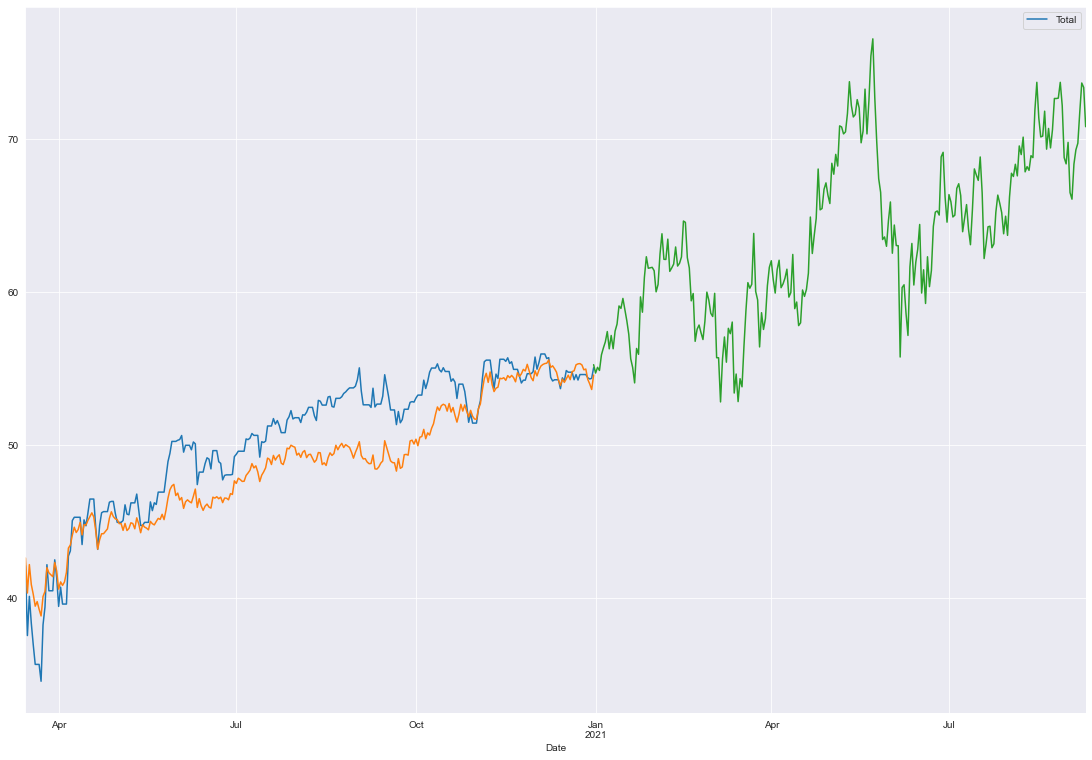

In [25]:
# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()

# Figure out optimum lags for this data set
lags = ar_select_order(tot_port_df, maxlag=30)
print("Lags :", lags.ar_lags)

# Create our model using whole data set
model = AutoReg(tot_port_df['Total'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
print("Observations :", len(tot_port_df)) # 1095 observations

train_df = tot_port_df.iloc[0:1167] # First 80% 
test_df = tot_port_df.iloc[1167:] # Last 20%

# Define training model for 459 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(tot_port_df['Total'], 459).fit(cov_type="HC0")

# # Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # blue
ax = prediction.plot(ax=ax) # orange

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+252, dynamic=True)
ax = forecast.plot(ax=ax) # Green

## Calculate annualized returns for forecasted

In [26]:
forecast

2020-12-31    55.251599
2021-01-01    54.704217
2021-01-02    55.077792
2021-01-03    54.875998
2021-01-04    55.889902
                ...    
2021-09-05    69.722888
2021-09-06    71.778407
2021-09-07    73.658376
2021-09-08    73.371277
2021-09-09    70.803459
Freq: D, Length: 253, dtype: float64

In [27]:
forecast_df = pd.DataFrame(forecast)

In [28]:
forecast_df

,0
2020-12-31,55.251599
2021-01-01,54.704217
2021-01-02,55.077792
2021-01-03,54.875998
2021-01-04,55.889902
...,...
2021-09-05,69.722888
2021-09-06,71.778407
2021-09-07,73.658376
2021-09-08,73.371277


In [29]:
return_series = (1 + forecast_df.pct_change()).cumprod() - 1

In [30]:
return_series

,0
2020-12-31,NaN
2021-01-01,-0.009907
2021-01-02,-0.003146
2021-01-03,-0.006798
2021-01-04,0.011553
...,...
2021-09-05,0.261916
2021-09-06,0.299119
2021-09-07,0.333145
2021-09-08,0.327948


In [31]:
#calculate annualized return
total_return = return_series.tail(1)

annualized_return = ((1 + total_return)**(1))-1

print(annualized_return*100)

                    0
2021-09-09  28.147347


## Backtesting

In [32]:
tickers2 = ['LHX','ODFL','SAIA','AXP','TROW','CG','CSWC','CBRE','SBAC','EPAM','QCOM','ASML','DSGX',
          'MGIC','RDWR','CTLT','BRKR','ICLR','MODV','^FVX']

#change the date according to the year you want to backtest and compare with forecasted
start_date = '2020-12-31'
end_date = '2021-12-30'

panel_data2 = data.DataReader(tickers2,'yahoo', start_date, end_date)

In [33]:
panel_data2 = panel_data2['Adj Close']

In [34]:
panel_data2

Symbols,LHX,ODFL,SAIA,AXP,TROW,CG,CSWC,CBRE,SBAC,EPAM,QCOM,ASML,DSGX,MGIC,RDWR,CTLT,BRKR,ICLR,MODV,^FVX
Date,,,,,,,,,,,,,,,,,,,,
2020-12-30,183.303925,192.874634,182.320007,117.758209,142.749695,30.581202,16.510555,62.400002,271.858215,358.480011,146.624542,487.229980,58.139999,15.175845,27.559999,103.190002,53.357384,193.660004,137.899994,0.370
2020-12-31,184.642197,194.428650,180.800003,119.217506,144.477051,30.600670,16.862047,62.720001,279.353729,358.350006,148.961548,485.051971,58.480000,15.098663,27.750000,104.070000,53.975616,194.979996,138.630005,0.361
2021-01-04,176.260925,189.955948,179.929993,116.387672,140.945984,30.279476,16.938046,59.500000,272.917725,348.059998,145.206696,497.264801,57.730000,14.432972,27.280001,103.730003,53.157955,192.020004,141.360001,0.354
2021-01-05,178.126663,191.011856,180.860001,117.008850,142.282059,30.600670,16.890547,59.419998,269.897705,345.700012,149.049561,502.595459,58.820000,14.375086,27.350000,104.830002,54.165073,195.690002,145.679993,0.377
2021-01-06,178.536957,192.555893,187.009995,121.337395,144.610657,30.201612,16.748049,60.610001,262.035889,329.660004,147.837036,487.538300,57.200001,14.124245,27.400000,106.239998,56.109516,205.479996,155.580002,0.432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,207.347183,347.977234,323.529999,163.778946,193.571014,55.196152,24.795002,105.820000,373.462097,663.080017,181.980865,801.409973,80.900002,20.666519,38.340000,124.959999,80.223610,307.929993,152.139999,1.243
2021-12-27,209.408127,355.260284,333.049988,163.978439,197.565552,55.852657,24.579479,107.790001,382.522247,697.000000,185.555954,811.429993,81.820000,21.160698,40.820000,126.360001,82.701866,307.619995,151.100006,1.252
2021-12-28,211.230103,356.299286,330.190002,163.998398,197.654755,55.176258,24.520700,107.720001,383.889252,682.200012,184.052231,804.770020,82.000000,20.824657,40.430000,125.360001,82.022346,306.049988,149.979996,1.245


## Portfolio Analysis

In [35]:
return_series2 = panel_data2.pct_change().dropna()
return_series2.head()

Symbols,LHX,ODFL,SAIA,AXP,TROW,CG,CSWC,CBRE,SBAC,EPAM,QCOM,ASML,DSGX,MGIC,RDWR,CTLT,BRKR,ICLR,MODV,^FVX
Date,,,,,,,,,,,,,,,,,,,,
2020-12-31,0.007301,0.008057,-0.008337,0.012392,0.012101,0.000637,0.021289,0.005128,0.027571,-0.000363,0.015939,-0.004470,0.005848,-0.005086,0.006894,0.008528,0.011587,0.006816,0.005294,-0.024324
2021-01-04,-0.045392,-0.023004,-0.004812,-0.023737,-0.024440,-0.010496,0.004507,-0.051339,-0.023039,-0.028715,-0.025207,0.025178,-0.012825,-0.044089,-0.016937,-0.003267,-0.015149,-0.015181,0.019693,-0.019391
2021-01-05,0.010585,0.005559,0.005169,0.005337,0.009479,0.010608,-0.002804,-0.001345,-0.011066,-0.006780,0.026465,0.010720,0.018881,-0.004011,0.002566,0.010604,0.018946,0.019113,0.030560,0.064972
2021-01-06,0.002303,0.008083,0.034004,0.036993,0.016366,-0.013041,-0.008437,0.020027,-0.029129,-0.046399,-0.008135,-0.029959,-0.027542,-0.017450,0.001828,0.013450,0.035898,0.050028,0.067957,0.145889
2021-01-07,-0.008317,0.044801,0.036790,-0.007910,0.019930,0.014180,0.044243,0.014684,0.002305,0.026755,0.029830,0.022867,0.024475,0.019126,0.015328,0.021931,0.031100,0.019321,0.046150,0.050926


In [36]:
portfolio_weights = [0.0145161,0.068463,0.0070209,0.00164655,0.01234755,0.0179883,0.0130176,0.033096,
               0.071904,0.0091785,2.43E-05,0.0103785,0.0060897,0.0027567,0.0015723,0.0087756,
               0.0066555,0.0100752,0.0044937,0.7]

#apply the weights to returns
wt_portfolio = return_series2 * portfolio_weights
wt_portfolio.head()

Symbols,LHX,ODFL,SAIA,AXP,TROW,CG,CSWC,CBRE,SBAC,EPAM,QCOM,ASML,DSGX,MGIC,RDWR,CTLT,BRKR,ICLR,MODV,^FVX
Date,,,,,,,,,,,,,,,,,,,,
2020-12-31,0.000106,0.000552,-0.000059,0.000020,0.000149,0.000011,0.000277,0.000170,0.001982,-0.000003,3.873106e-07,-0.000046,0.000036,-0.000014,0.000011,0.000075,0.000077,0.000069,0.000024,-0.017027
2021-01-04,-0.000659,-0.001575,-0.000034,-0.000039,-0.000302,-0.000189,0.000059,-0.001699,-0.001657,-0.000264,-6.125266e-07,0.000261,-0.000078,-0.000122,-0.000027,-0.000029,-0.000101,-0.000153,0.000088,-0.013573
2021-01-05,0.000154,0.000381,0.000036,0.000009,0.000117,0.000191,-0.000037,-0.000044,-0.000796,-0.000062,6.430944e-07,0.000111,0.000115,-0.000011,0.000004,0.000093,0.000126,0.000193,0.000137,0.045480
2021-01-06,0.000033,0.000553,0.000239,0.000061,0.000202,-0.000235,-0.000110,0.000663,-0.002094,-0.000426,-1.976815e-07,-0.000311,-0.000168,-0.000048,0.000003,0.000118,0.000239,0.000504,0.000305,0.102122
2021-01-07,-0.000121,0.003067,0.000258,-0.000013,0.000246,0.000255,0.000576,0.000486,0.000166,0.000246,7.248706e-07,0.000237,0.000149,0.000053,0.000024,0.000192,0.000207,0.000195,0.000207,0.035648


In [37]:
portfolio_returns1 = wt_portfolio.sum(axis = 1)
portfolio_returns1.head()

Date
2020-12-31   -0.013590
2021-01-04   -0.020091
2021-01-05    0.046197
2021-01-06    0.101651
2021-01-07    0.042080
dtype: float64

/opt/anaconda3/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


Start date,2020-12-31
End date,2021-12-30
Total months,12
,Backtest
Annual return,190.7%
Cumulative returns,190.7%
Annual volatility,52.0%
Sharpe ratio,2.31
Calmar ratio,9.52
Stability,0.79
Max drawdown,-20.0%


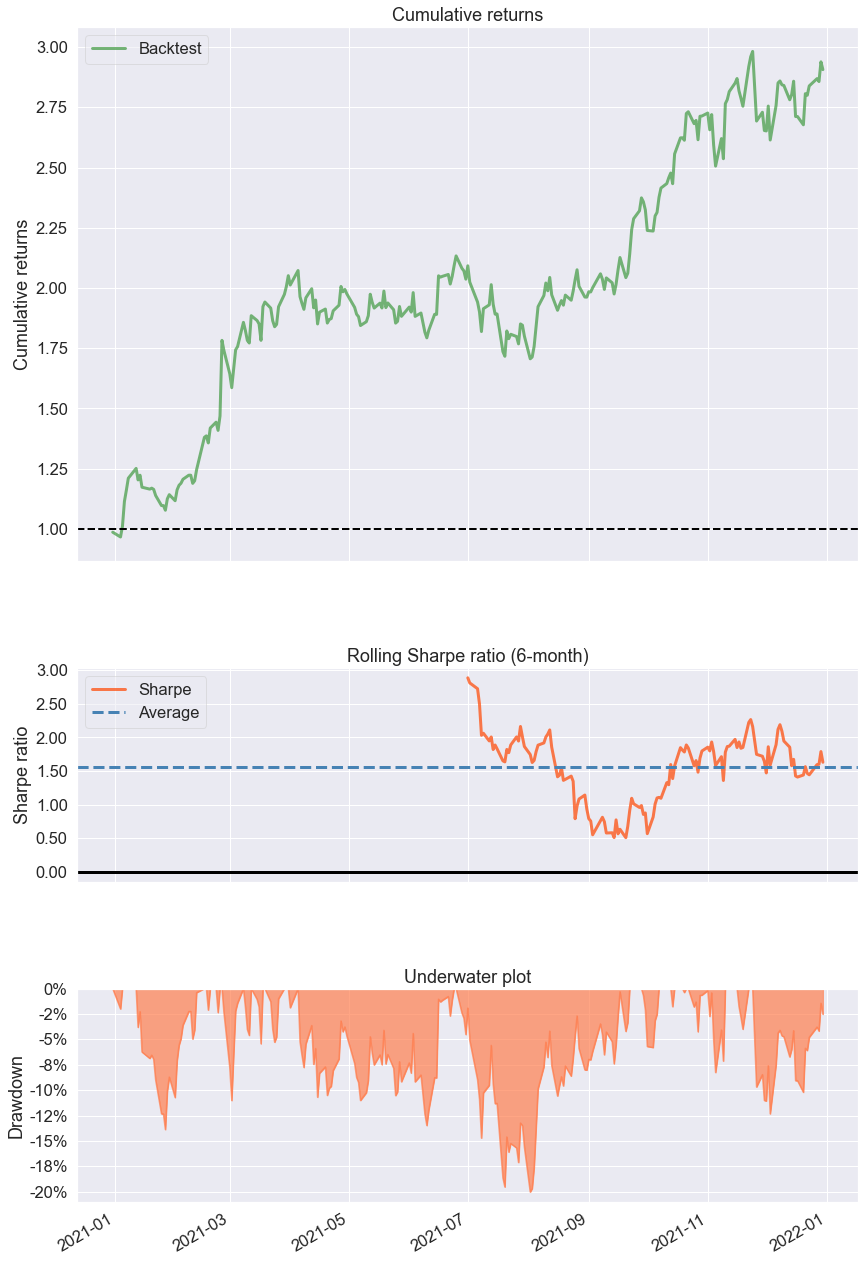

In [38]:
import pyfolio as pf
pf.create_simple_tear_sheet(portfolio_returns1)

## Extra stuff

In [39]:
import itertools

In [40]:
weights = [0.0145161,0.068463,0.0070209,0.00164655,0.01234755,0.0179883,0.0130176,0.033096,
               0.071904,0.0091785,2.43E-05,0.0103785,0.0060897,0.0027567,0.0015723,0.0087756,
               0.0066555,0.0100752,0.0044937,0.7]

In [41]:
panel_data2 = panel_data2 * weights

In [42]:
num_cols = len(panel_data2.columns)
    
# Create a new column with the sums of all stocks named Total
panel_data2['Total'] = panel_data2.iloc[:, 0:num_cols].sum(axis=1)

In [43]:
#forecasted portfolio value
panel_data2

Symbols,LHX,ODFL,SAIA,AXP,TROW,CG,CSWC,CBRE,SBAC,EPAM,...,ASML,DSGX,MGIC,RDWR,CTLT,BRKR,ICLR,MODV,^FVX,Total
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-30,2.660858,13.204776,1.280051,0.193895,1.762609,0.550104,0.214928,2.065190,19.547693,3.290309,...,5.056716,0.354055,0.041835,0.043333,0.905554,0.355120,1.951163,0.619681,0.2590,54.360433
2020-12-31,2.680285,13.311169,1.269379,0.196298,1.783938,0.550454,0.219503,2.075781,20.086651,3.289116,...,5.034112,0.356126,0.041622,0.043631,0.913277,0.359235,1.964462,0.622962,0.2527,55.054318
2021-01-04,2.558621,13.004954,1.263270,0.191638,1.740338,0.544676,0.220493,1.969212,19.623876,3.194669,...,5.160863,0.351558,0.039787,0.042892,0.910293,0.353793,1.934640,0.635229,0.2478,53.992132
2021-01-05,2.585704,13.077245,1.269800,0.192661,1.756835,0.550454,0.219874,1.966564,19.406725,3.173008,...,5.216187,0.358196,0.039628,0.043002,0.919946,0.360496,1.971616,0.654642,0.2639,54.030105
2021-01-06,2.591660,13.182954,1.312978,0.199788,1.785587,0.543276,0.218019,2.005949,18.841429,3.025784,...,5.059916,0.348331,0.038936,0.043081,0.932320,0.373437,2.070252,0.699130,0.3024,53.578820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,3.009872,23.823565,2.271472,0.269670,2.390128,0.992885,0.322771,3.502219,26.853419,6.086080,...,8.317433,0.492657,0.056971,0.060282,1.096599,0.533928,3.102456,0.683672,0.8701,84.740602
2021-12-27,3.039789,24.322185,2.338311,0.269999,2.439451,1.004694,0.319966,3.567418,27.504880,6.397414,...,8.421426,0.498259,0.058334,0.064181,1.108885,0.550422,3.099333,0.678998,0.8764,86.564854
2021-12-28,3.066237,24.393318,2.318231,0.270032,2.440552,0.992527,0.319201,3.565101,27.603173,6.261573,...,8.352306,0.499355,0.057407,0.063568,1.100109,0.545900,3.083515,0.673965,0.8715,86.482042


In [44]:
actual_portfolio_value = []

for value in panel_data2['Total']:
    actual_portfolio_value.append(value)

In [45]:
actual_portfolio_value

[54.36043349435434,
 55.05431846471825,
 53.99213175677033,
 54.03010485290204,
 53.57882019404315,
 54.6468384401971,
 55.32781477030324,
 54.623993707099714,
 54.81417064567566,
 54.84468063545724,
 55.76126851997986,
 55.961994411640546,
 56.430386527678294,
 57.04927683279819,
 57.00164387631301,
 56.713256961406884,
 57.27941645090924,
 56.6324249668768,
 54.68269168553065,
 55.40535181174574,
 54.481402809537215,
 56.06435559243688,
 57.059876437088974,
 55.70891809349499,
 56.70623041204233,
 57.02808879729118,
 57.239235250090026,
 57.520836288512605,
 57.12220878887023,
 57.43206782766074,
 57.84198905050753,
 57.39250627950133,
 56.99340279311179,
 57.1926723877161,
 57.723392908323476,
 57.015222431538966,
 56.237589790056795,
 56.929843306334774,
 56.55442010420179,
 56.3794888094226,
 56.724112218447694,
 56.60248524315997,
 55.87244674324799,
 54.292061544959445,
 55.46196983304185,
 55.10227894569243,
 56.45663621420821,
 56.66671761606819,
 57.99332684289646,
 58.486371

In [46]:
forecasted_portfolio_value = []

for value in forecast_df[0]:
    forecasted_portfolio_value.append(value)

In [47]:
forecasted_portfolio_value

[55.251599367508994,
 54.704217376818136,
 55.0777918362384,
 54.87599781686012,
 55.88990209747114,
 56.34534690185142,
 56.743311034993134,
 57.416053798261764,
 56.28862093847348,
 57.15986662208784,
 56.29169902181425,
 57.448535571970545,
 57.90461355850691,
 59.08922420854121,
 58.93151592740129,
 59.58159354236182,
 58.85112835458036,
 58.12491659815804,
 57.242339215607515,
 55.6360950985611,
 55.064512167762885,
 54.061256159048156,
 56.312062170279546,
 55.92890365511324,
 59.68292152919516,
 58.68109656540166,
 60.954908482424706,
 62.305626431542045,
 61.55204483852939,
 61.584232118128014,
 61.613135413705635,
 61.39195713073521,
 60.01165375496462,
 60.4901331760717,
 62.487636983132525,
 63.80805361080055,
 62.138094514003676,
 62.127328078048265,
 63.456532288733705,
 61.34931408514658,
 61.57304407937338,
 61.82764008417856,
 62.943471816449,
 61.696724821978556,
 61.87793423643715,
 62.293145413237816,
 64.63923188602749,
 64.55358081708081,
 62.23853113144602,
 61.57

## Calculate MAPE of forecasted period

In [48]:
# Define the dataset as python lists
# actual = [136, 120, 138, 155, 149]
# forecast = [134, 124, 132, 141, 149]

# Consider a list APE to store the
# APE value for each of the records in dataset
APE = []

# Iterate over the list values
for day in range(253):

	# Calculate percentage error
	per_err = (actual_portfolio_value[day] - forecasted_portfolio_value[day]) / actual_portfolio_value[day]

	# Take absolute value of
	# the percentage error (APE)
	per_err = abs(per_err)

	# Append it to the APE list
	APE.append(per_err)

# Calculate the MAPE
MAPE = sum(APE)/len(APE)

# Print the MAPE value and percentage
print(f'''
MAPE : { round(MAPE, 2) }
MAPE % : { round(MAPE*100, 2) } %
''')


MAPE : 0.11
MAPE % : 10.98 %



## Mean Squared Error

In [49]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(actual_portfolio_value, forecasted_portfolio_value))

98.66551817183306


## Forecast for future

In [50]:
#change to the list of stocks we using
port_list = ['LHX','ODFL','SAIA','AXP','TROW','CG','CSWC','CBRE','SBAC','EPAM','QCOM','ASML','DSGX',
          'MGIC','RDWR','CTLT','BRKR','ICLR','MODV','^FVX']

#add in the weightage of stocks
port_shares = [0.0145161,0.068463,0.0070209,0.00164655,0.01234755,0.0179883,0.0130176,0.033096,
               0.071904,0.0091785,2.43E-05,0.0103785,0.0060897,0.0027567,0.0015723,0.0087756,
               0.0066555,0.0100752,0.0044937,0.7]

# tot_port_df = get_port_daily_return('2020-01-02', '2020-12-31', 
#                                     port_shares, port_list)

#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2021-12-31', port_shares, port_list)
tot_port_df

,LHX,ODFL,SAIA,AXP,TROW,CG,CSWC,CBRE,SBAC,EPAM,...,DSGX,MGIC,RDWR,CTLT,BRKR,ICLR,MODV,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,1.361084,3.881016,0.315238,0.114898,0.799618,0.219965,0.166078,1.044841,7.444281,0.584303,...,0.129406,0.016184,0.023081,0.236941,0.140677,0.752718,0.172423,1.3608,19.856813,NaN
2017-01-04,1.368504,3.897116,0.316292,0.116782,0.811533,0.226310,0.170144,1.061720,7.454863,0.590728,...,0.130624,0.016302,0.023207,0.239662,0.142111,0.773977,0.176962,1.3629,19.967756,0.005587
2017-01-05,1.370226,3.851052,0.308569,0.115342,0.805207,0.229835,0.169941,1.052784,7.356104,0.594308,...,0.128797,0.016419,0.023097,0.236064,0.142437,0.767831,0.176153,1.3041,19.749337,-0.010939
2017-01-06,1.385332,3.850606,0.315098,0.115572,0.797299,0.234770,0.167705,1.032595,7.302493,0.613766,...,0.129406,0.016302,0.023034,0.235888,0.143676,0.792414,0.177276,1.3454,19.778517,0.001478
2017-01-09,1.353398,3.829586,0.309622,0.116169,0.767882,0.235475,0.169941,1.030278,7.265105,0.613491,...,0.129102,0.016302,0.022798,0.236151,0.145240,0.809744,0.175973,1.3167,19.656389,-0.006175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,3.039789,24.322185,2.338311,0.269999,2.439451,1.004694,0.319966,3.567418,27.504880,6.397414,...,0.498259,0.058334,0.064181,1.108885,0.550422,3.099333,0.678998,0.8764,86.564854,0.021527
2021-12-28,3.066237,24.393318,2.318231,0.270032,2.440552,0.992527,0.319201,3.565101,27.603173,6.261573,...,0.499355,0.057407,0.063568,1.100109,0.545900,3.083515,0.673965,0.8715,86.482042,-0.000957
2021-12-29,3.069272,24.678536,2.354880,0.269079,2.417665,0.972845,0.317543,3.593564,27.618959,6.221555,...,0.502035,0.057516,0.065203,1.123979,0.556807,3.103061,0.675044,0.9058,86.831197,0.004037


In [51]:
#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2021-12-31', 
                                    port_shares, port_list)
tot_port_df

,LHX,ODFL,SAIA,AXP,TROW,CG,CSWC,CBRE,SBAC,EPAM,...,DSGX,MGIC,RDWR,CTLT,BRKR,ICLR,MODV,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,1.361084,3.881016,0.315238,0.114898,0.799618,0.219965,0.166078,1.044841,7.444281,0.584303,...,0.129406,0.016184,0.023081,0.236941,0.140677,0.752718,0.172423,1.3608,19.856813,NaN
2017-01-04,1.368504,3.897116,0.316292,0.116782,0.811533,0.226310,0.170144,1.061720,7.454863,0.590728,...,0.130624,0.016302,0.023207,0.239662,0.142111,0.773977,0.176962,1.3629,19.967756,0.005587
2017-01-05,1.370226,3.851052,0.308569,0.115342,0.805207,0.229835,0.169941,1.052784,7.356104,0.594308,...,0.128797,0.016419,0.023097,0.236064,0.142437,0.767831,0.176153,1.3041,19.749337,-0.010939
2017-01-06,1.385332,3.850606,0.315098,0.115572,0.797299,0.234770,0.167705,1.032595,7.302493,0.613766,...,0.129406,0.016302,0.023034,0.235888,0.143676,0.792414,0.177276,1.3454,19.778517,0.001478
2017-01-09,1.353398,3.829586,0.309622,0.116169,0.767882,0.235475,0.169941,1.030278,7.265105,0.613491,...,0.129102,0.016302,0.022798,0.236151,0.145240,0.809744,0.175973,1.3167,19.656389,-0.006175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,3.039789,24.322185,2.338311,0.269999,2.439451,1.004694,0.319966,3.567418,27.504880,6.397414,...,0.498259,0.058334,0.064181,1.108885,0.550422,3.099333,0.678998,0.8764,86.564854,0.021527
2021-12-28,3.066237,24.393318,2.318231,0.270032,2.440552,0.992527,0.319201,3.565101,27.603173,6.261573,...,0.499355,0.057407,0.063568,1.100109,0.545900,3.083515,0.673965,0.8715,86.482042,-0.000957
2021-12-29,3.069272,24.678536,2.354880,0.269079,2.417665,0.972845,0.317543,3.593564,27.618959,6.221555,...,0.502035,0.057516,0.065203,1.123979,0.556807,3.103061,0.675044,0.9058,86.831197,0.004037


In [52]:
tot_port_df = tot_port_df.asfreq('d')
tot_port_df.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
               '2017-01-11', '2017-01-12',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Date', length=1824, freq='D')

In [53]:
# Delete NaNs for nontrading days
tot_port_df = tot_port_df.fillna(method='ffill')

In [54]:
tot_port_df

,LHX,ODFL,SAIA,AXP,TROW,CG,CSWC,CBRE,SBAC,EPAM,...,DSGX,MGIC,RDWR,CTLT,BRKR,ICLR,MODV,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,1.361084,3.881016,0.315238,0.114898,0.799618,0.219965,0.166078,1.044841,7.444281,0.584303,...,0.129406,0.016184,0.023081,0.236941,0.140677,0.752718,0.172423,1.3608,19.856813,NaN
2017-01-04,1.368504,3.897116,0.316292,0.116782,0.811533,0.226310,0.170144,1.061720,7.454863,0.590728,...,0.130624,0.016302,0.023207,0.239662,0.142111,0.773977,0.176962,1.3629,19.967756,0.005587
2017-01-05,1.370226,3.851052,0.308569,0.115342,0.805207,0.229835,0.169941,1.052784,7.356104,0.594308,...,0.128797,0.016419,0.023097,0.236064,0.142437,0.767831,0.176153,1.3041,19.749337,-0.010939
2017-01-06,1.385332,3.850606,0.315098,0.115572,0.797299,0.234770,0.167705,1.032595,7.302493,0.613766,...,0.129406,0.016302,0.023034,0.235888,0.143676,0.792414,0.177276,1.3454,19.778517,0.001478
2017-01-07,1.385332,3.850606,0.315098,0.115572,0.797299,0.234770,0.167705,1.032595,7.302493,0.613766,...,0.129406,0.016302,0.023034,0.235888,0.143676,0.792414,0.177276,1.3454,19.778517,0.001478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,3.039789,24.322185,2.338311,0.269999,2.439451,1.004694,0.319966,3.567418,27.504880,6.397414,...,0.498259,0.058334,0.064181,1.108885,0.550422,3.099333,0.678998,0.8764,86.564854,0.021527
2021-12-28,3.066237,24.393318,2.318231,0.270032,2.440552,0.992527,0.319201,3.565101,27.603173,6.261573,...,0.499355,0.057407,0.063568,1.100109,0.545900,3.083515,0.673965,0.8715,86.482042,-0.000957
2021-12-29,3.069272,24.678536,2.354880,0.269079,2.417665,0.972845,0.317543,3.593564,27.618959,6.221555,...,0.502035,0.057516,0.065203,1.123979,0.556807,3.103061,0.675044,0.9058,86.831197,0.004037


In [55]:
# Delete all unneeded columns - basically delete all except Total
del_col = ['LHX','ODFL','SAIA','AXP','TROW','CG','CSWC','CBRE','SBAC','EPAM','QCOM','ASML','DSGX',
          'MGIC','RDWR','CTLT','BRKR','ICLR','MODV','^FVX', "daily_return"]

for x in del_col:
    tot_port_df = tot_port_df.drop([x], axis=1)

In [56]:
tot_port_df

,Total
Date,
2017-01-03,19.856813
2017-01-04,19.967756
2017-01-05,19.749337
2017-01-06,19.778517
2017-01-07,19.778517
...,...
2021-12-27,86.564854
2021-12-28,86.482042
2021-12-29,86.831197


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use t

Lags : [1 2]
Observations : 1824


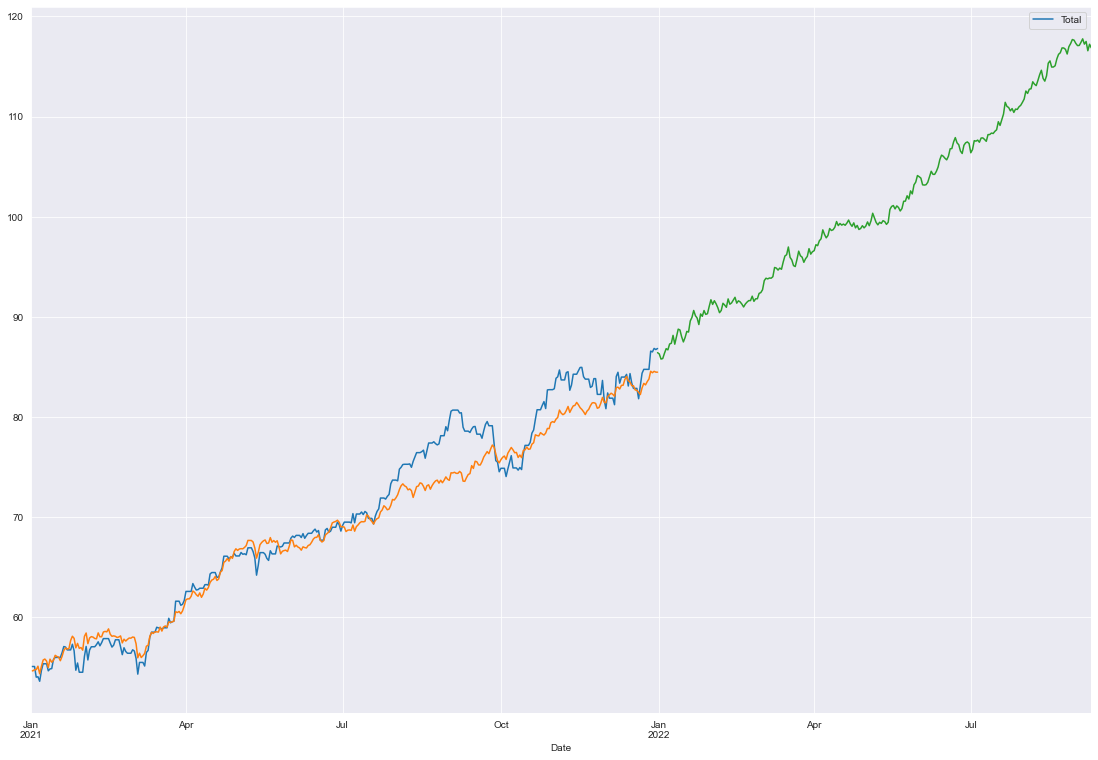

In [57]:
# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()

# Figure out optimum lags for this data set
lags = ar_select_order(tot_port_df, maxlag=30)
print("Lags :", lags.ar_lags)

# Create our model using whole data set
model = AutoReg(tot_port_df['Total'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
print("Observations :", len(tot_port_df)) # 1095 observations

train_df = tot_port_df.iloc[0:1459] # First 80% 
test_df = tot_port_df.iloc[1459:] # Last 20%

# Define training model for 459 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(tot_port_df['Total'], 459).fit(cov_type="HC0")

# # Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # blue
ax = prediction.plot(ax=ax) # orange

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+252, dynamic=True)
ax = forecast.plot(ax=ax) # Green

In [58]:
## Calculate annualized returns for forecasted

In [59]:
forecast

2021-12-31     86.406985
2022-01-01     86.280574
2022-01-02     85.769133
2022-01-03     85.819367
2022-01-04     86.341225
                 ...    
2022-09-05    117.232434
2022-09-06    117.498236
2022-09-07    116.569971
2022-09-08    117.219637
2022-09-09    116.862012
Freq: D, Length: 253, dtype: float64

In [60]:
forecast_df = pd.DataFrame(forecast)

In [61]:
forecast_df

,0
2021-12-31,86.406985
2022-01-01,86.280574
2022-01-02,85.769133
2022-01-03,85.819367
2022-01-04,86.341225
...,...
2022-09-05,117.232434
2022-09-06,117.498236
2022-09-07,116.569971
2022-09-08,117.219637


In [62]:
return_series = (1 + forecast_df.pct_change()).cumprod() - 1

In [63]:
return_series

,0
2021-12-31,NaN
2022-01-01,-0.001463
2022-01-02,-0.007382
2022-01-03,-0.006801
2022-01-04,-0.000761
...,...
2022-09-05,0.356747
2022-09-06,0.359823
2022-09-07,0.349080
2022-09-08,0.356599


In [64]:
#calculate annualized return
total_return = return_series.tail(1)

annualized_return = ((1 + total_return)**(1))-1

print(annualized_return*100)

                    0
2022-09-09  35.246024
